In [1]:
import BioSimSpace as BSS
import sys

import warnings
warnings.filterwarnings(action='once')


try:
    import pipeline
except:
    print("adding code to the pythonpath...")
    code = '/home/anna/Documents/code/python'
    if code not in sys.path:
        sys.path.insert(1, code)
    import pipeline

from pipeline import *
from pipeline.analysis import *

/home/anna/anaconda3/envs/biosimspace-dev/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/anna/anaconda3/envs/biosimspace-dev/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/anna/anaconda3/envs/biosimspace-dev/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/anna/anaconda3/envs/biosimspace-dev/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


adding code to the pythonpath...


There are 3 repeats for each the bound and the free for /home/anna/Documents/code/test/AMBER_extracted/lig_ejm31~lig_ejm42.these are ['bound_0', 'bound_1', 'bound_2'] and ['free_0', 'free_1', 'free_2'].
False
trying to locate pickles in default pickle folder, /home/anna/Documents/code/test/AMBER_extracted/lig_ejm31~lig_ejm42/pickle for lig_ejm31~lig_ejm42_AMBER_MBAR_alchemlyb_eqfalse_statsfalse_truncate0end...
pickles found!
There are 3 calculated values for each the bound and the free leg for the folders in /home/anna/Documents/code/test/AMBER_extracted/lig_ejm31~lig_ejm42.
already using pickles, will not be saving again.


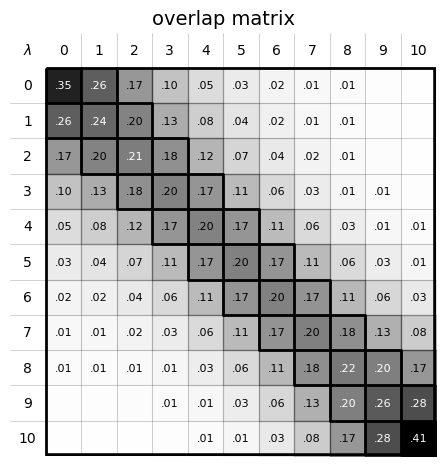

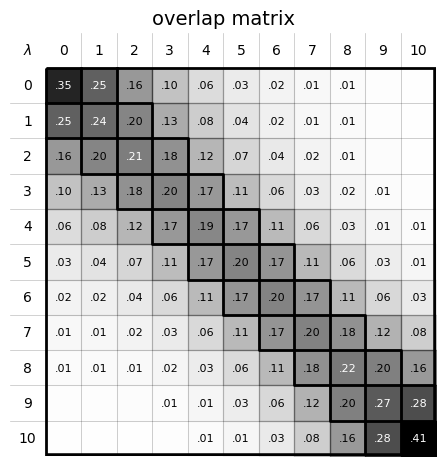

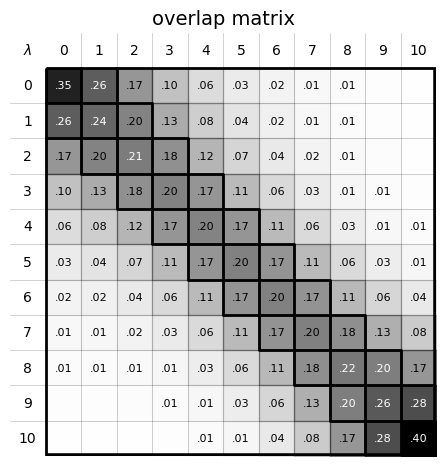

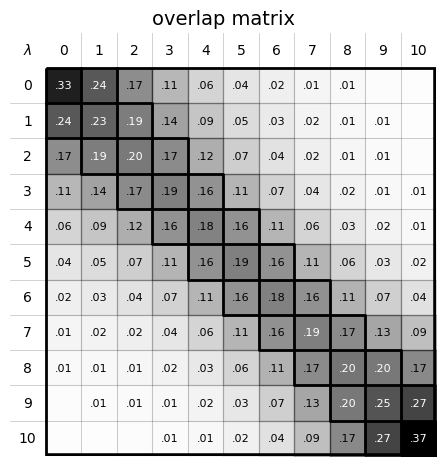

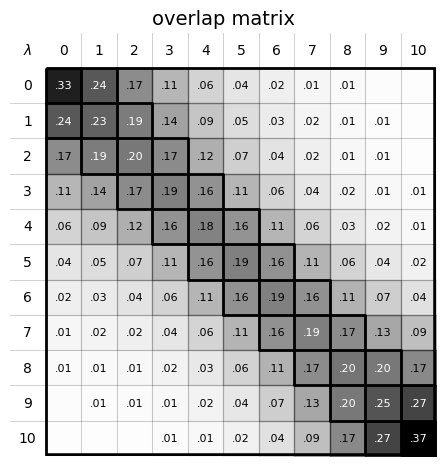

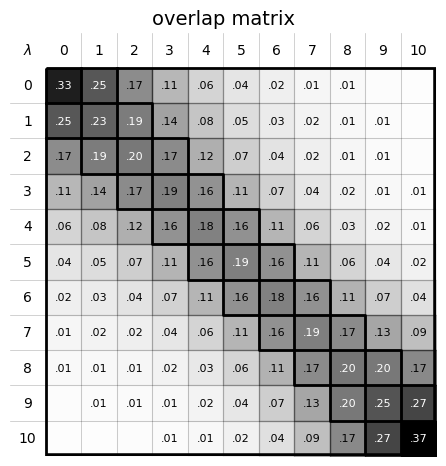

In [4]:
work_dir = "/home/anna/Documents/code/test/AMBER_extracted/lig_ejm31~lig_ejm42"
analysis = pipeline.analysis.analyse(work_dir)

analysis_options = {'estimator': "MBAR", "method":"alchemlyb",
                    "check_overlap":True,
                    "try_pickle":True, 'save_pickle':True,
                    "auto_equilibration": False,
                    "truncate_percentage": 0}#

analysis.set_options(analysis_options)
print(analysis._analysed_all)
analysis.analyse_all_repeats()
analysis.plot_graphs()